In [54]:
import pandas as pd
import numpy as np

from cbsyst.MyAMI_V2 import func_K1K2
from scipy.optimize import curve_fit

from cbsyst import MyAMI_K_calc

import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
lk = pd.read_csv('Luecker2000_Table2.csv', comment='#')
lk.TempK = lk.TempC + 273.15
lk.K1 = 10**-lk.pK1
lk.K2 = 10**-lk.pK2

In [48]:
# make grid
aTemp = np.linspace(0,40)
aSal = np.linspace(20,40)
gTemp, gSal = np.meshgrid(aTemp, aSal)
gTempK = gTemp + 273.15

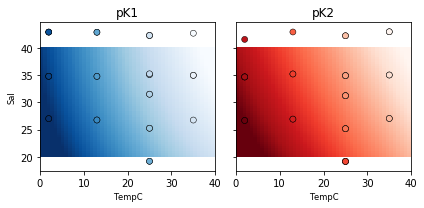

In [60]:
# Luecker Equations
def Luek_pK1(TempK, Sal):
    return 3633.86 / TempK - 61.2172 + 9.6777 * np.log(TempK) - 0.011555 * Sal + 0.0001152 * Sal**2

def Luek_pK2(TempK, Sal):
    return 471.78 / TempK + 25.9290 - 3.16967 * np.log(TempK) - 0.01781 * Sal + 0.0001122 * Sal**2

LpK1 = Luek_pK1(gTempK, gSal)
LpK2 = Luek_pK2(gTempK, gSal)

fig, axs = plt.subplots(1, 2, figsize=(6,3), sharey=True)

ax1, ax2 = axs

# K1
ax1.set_title('pK1')
ax1.scatter(lk.TempC, lk.Sal, c=lk.pK1, cmap=plt.cm.Blues, lw=0.5, edgecolor='k',
            vmin=lk.pK1.min(), vmax=lk.pK1.max())
c1 = ax1.pcolormesh(gTemp, gSal, LpK1, zorder=-1,
                    cmap=plt.cm.Blues, vmin=lk.pK1.min(), vmax=lk.pK1.max())

# K2
ax2.set_title('pK2')
ax2.scatter(lk.TempC, lk.Sal, c=lk.pK2, cmap=plt.cm.Reds, lw=0.5, edgecolor='k',
            vmin=lk.pK2.min(), vmax=lk.pK2.max())
ax2.pcolormesh(gTemp, gSal, LpK2, zorder=-1,
               cmap=plt.cm.Reds, vmin=lk.pK2.min(), vmax=lk.pK2.max())

for ax in axs:
    ax.set_xlabel('TempC')
ax1.set_ylabel('Sal')
fig.tight_layout()

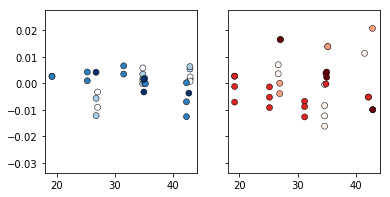

In [71]:
# Luecker Residuals
LrpK1 = lk.pK1 - Luek_pK1(lk.TempK, lk.Sal)
LrpK2 = lk.pK2 - Luek_pK2(lk.TempK, lk.Sal)

fig, axs = plt.subplots(1, 2, figsize=(6,3), sharey=True)

ax1, ax2 = axs

ax1.scatter(lk.Sal, LrpK1, c=lk.TempC, cmap=plt.cm.Blues, lw=0.5, edgecolor='k')

ax2.scatter(lk.Sal, LrpK2, c=lk.TempC, cmap=plt.cm.Reds, lw=0.5, edgecolor='k')

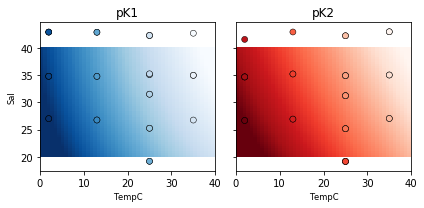

In [59]:
# MyAMI Equations
Ks = MyAMI_K_calc(TempC=gTemp, Sal=gSal)

fig, axs = plt.subplots(1, 2, figsize=(6,3), sharey=True)

ax1, ax2 = axs

# K1
ax1.set_title('pK1')
ax1.scatter(lk.TempC, lk.Sal, c=lk.pK1, cmap=plt.cm.Blues, lw=0.5, edgecolor='k',
            vmin=lk.pK1.min(), vmax=lk.pK1.max())
c1 = ax1.pcolormesh(gTemp, gSal, -np.log10(Ks.K1), zorder=-1,
                    cmap=plt.cm.Blues, vmin=lk.pK1.min(), vmax=lk.pK1.max())

# K2
ax2.set_title('pK2')
ax2.scatter(lk.TempC, lk.Sal, c=lk.pK2, cmap=plt.cm.Reds, lw=0.5, edgecolor='k',
            vmin=lk.pK2.min(), vmax=lk.pK2.max())
ax2.pcolormesh(gTemp, gSal, -np.log10(Ks.K2), zorder=-1,
               cmap=plt.cm.Reds, vmin=lk.pK2.min(), vmax=lk.pK2.max())

for ax in axs:
    ax.set_xlabel('TempC')
ax1.set_ylabel('Sal')
fig.tight_layout()

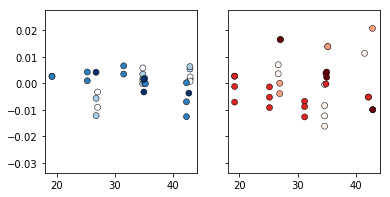

In [73]:
# MyAMI Residuals
lKs = MyAMI_K_calc(lk.TempC, lk.Sal)
MrpK1 = lk.pK1 - -np.log10(lKs.K1)
MrpK2 = lk.pK2 - -np.log10(lKs.K2)

fig, axs = plt.subplots(1, 2, figsize=(6,3), sharey=True)
ax1, ax2 = axs

ax1.scatter(lk.Sal, LrpK1, c=lk.TempC, cmap=plt.cm.Blues, lw=0.5, edgecolor='k')

ax2.scatter(lk.Sal, LrpK2, c=lk.TempC, cmap=plt.cm.Reds, lw=0.5, edgecolor='k')

In [115]:
# MrpK2.median()
np.percentile(MrpK2[~np.isnan(MrpK2)], (2.5, 97.5))

array([-0.01338709,  0.01735146])

In [ ]:
def test_CompareToMehrbachData():
    """
    Compares pK1 and pK2 calcualted by MyAMI_V2 to data from
    Mehrbach et al (1973), as per Lueker et al (2000).
    
    Test data on Total pH scale taken from Table 2 of Lueker et al (2000)
    """
    # read data
    lk = pd.read_csv('Luecker2000_Table2.csv', comment='#')
    
    # calculate MyAMI Ks
    mKs = MyAMI_K_calc(lk.TempC, lk.Sal)
    
    # calculate pK1 and pK2 2 residuals
    rpK1 = lk.pK1 - -np.log10(mKs.K1)
    rpK2 = lk.pK2 - -np.log10(mKs.K2)
    
    # calculate median and 95% CI of residuals
    rpK1_median = rpK1.median()
    rpK1_95ci = np.percentile(rpK1[~np.isnan(rpK1)], (2.5, 97.5))
    self.assertLessEqual(abs(rpK1_median), 0.005, msg='Median offset from Mehrbach (1973) pK1.')
    self.assertTrue(all(abs(rpK1_95ci) <= 0.02), msg='95% CI of difference from Mehrbach pK1 <= 0.02')
    
    rpK2_median = rpK1.median()
    rpK2_95ci = np.percentile(rpK2[~np.isnan(rpK2)], (2.5, 97.5))
    self.assertLessEqual(abs(rpK2_median), 0.005, msg='Median offset from Mehrbach (1973) pK2.')
    self.assertTrue(all(abs(rpK2_95ci) <= 0.02), msg='95% CI of difference from Mehrbach pK2 <= 0.02')

In [92]:
def limmer(x, pad=0.05):
    ax = np.asarray(x)
    mn = np.nanmin(ax)
    mx = np.nanmax(ax)
    rn = mx - mn
    return (mn - pad * rn, mx + pad * rn)

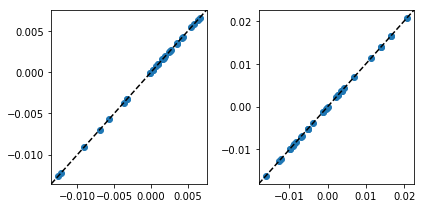

In [102]:
# MyAMI vs Luecker Residuals
fig, axs = plt.subplots(1, 2, figsize=(6,3))
ax1, ax2 = axs

ax1.scatter(LrpK1, MrpK1)
ls1 = limmer(LrpK1)
ax1.set_xlim(*ls1)
ax1.set_ylim(*ls1)
ax1.plot(ls1, ls1, c='k', ls='dashed')

ax2.scatter(LrpK2, MrpK2)
ls2 = limmer(LrpK2)
ax2.set_xlim(*ls2)
ax2.set_ylim(*ls2)
ax2.plot(ls2, ls2, c='k', ls='dashed')

fig.tight_layout()

In [38]:
ind = ~np.isnan(lk.K1)
curve_fit(func_K1K2, (lk.TempK[ind], lk.Sal[ind]), lk.K1[ind])

/Users/oscarbranson/GoogleDrive/tools/cbsyst/cbsyst/MyAMI_V2.py:1217: RuntimeWarning: overflow encountered in power
  e * Sal**2))
/Users/oscarbranson/anaconda/envs/py3/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([ 1.,  1.,  1.,  1.,  1.]), array([[ inf,  inf,  inf,  inf,  inf],
        [ inf,  inf,  inf,  inf,  inf],
        [ inf,  inf,  inf,  inf,  inf],
        [ inf,  inf,  inf,  inf,  inf],
        [ inf,  inf,  inf,  inf,  inf]]))

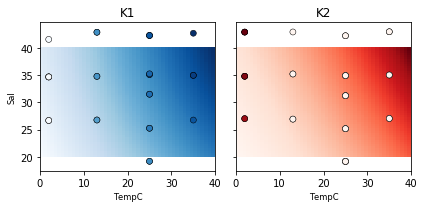

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(6,3), sharey=True)

ax1, ax2 = axs

# K1
ax1.set_title('K1')
ax1.scatter(lk.TempC, lk.Sal, c=lk.K1, cmap=plt.cm.Blues, lw=0.5, edgecolor='k')
ax1.pcolormesh(gTemp, gSal, func_K1K2((gTempK, gSal), *v1_params['K1']), zorder=-1,
               cmap=plt.cm.Blues)

# K2
ax2.set_title('K2')
ax2.scatter(lk.TempC, lk.Sal, c=lk.K2, cmap=plt.cm.Reds, lw=0.5, edgecolor='k')
ax2.pcolormesh(gTemp, gSal, func_K1K2((gTempK, gSal), *v1_params['K2']), zorder=-1,
               cmap=plt.cm.Reds)

for ax in axs:
    ax.set_xlabel('TempC')
ax1.set_ylabel('Sal')
fig.tight_layout()